In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from tqdm.notebook import tqdm
import h5py

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.signal import convolve2d
print(jax.devices())

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

[gpu(id=0)]


In [2]:
from aatw.units_constants import *
from aatw.geometry import *
from aatw.galactic_models import *
from aatw.nfw import *
from aatw.map_utils import *
from aatw.telescopes import CHIME
from aatw.spectral import prefac

## config

In [7]:
scheme = 'JF'
#gamma_NFW = 0.8

if scheme == 'AH':
    B_func = B_SRWE_AH
    n_e_func = n_e_SRWE
elif scheme == 'BH':
    B_func = B_SRWE_BH
    n_e_func = n_e_SRWE
elif scheme == 'JF':
    B_func = B_JF
    n_e_func = n_e_WMAP
else:
    raise ValueError(f'Unknown scheme.')

In [3]:
# CHIME 800 MHz resolution
def ra_pixel_size(nu, telescope): # [rad] ([MHz], ...)
    return (c0 / nu) / telescope.size_ra
print(f'CHIME pixel size at 800 MHz: {np.rad2deg(ra_pixel_size(800, CHIME)):.3f} deg')

CHIME pixel size at 800 MHz: 0.268 deg


In [4]:
# lower resolution map
pixel_size = 0.25 * deg # rad

n_b_pix = int(jnp.round(jnp.pi/pixel_size))
n_l_pix = int(jnp.round(2*jnp.pi/pixel_size))
b_edge_s = jnp.linspace(-jnp.pi/2, jnp.pi/2, n_b_pix+1)
l_edge_s = jnp.linspace(-jnp.pi, jnp.pi, n_l_pix+1)
b_s = (b_edge_s[:-1] + b_edge_s[1:]) / 2 # bin centers
l_s = (l_edge_s[:-1] + l_edge_s[1:]) / 2 # bin centers

l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.flatten(), b_grid.flatten()], axis=-1)

anti_l_grid = l_grid + jnp.pi
anti_l_grid = jnp.where(anti_l_grid > 2*jnp.pi, anti_l_grid - 2*jnp.pi, anti_l_grid)
anti_b_grid = - b_grid
anti_lb_flat = jnp.stack([anti_l_grid.ravel(), anti_b_grid.ravel()], axis=-1)

## functions

In [8]:
def power_density(stz):
    """Synchrotron intensity taking into account the direction of the B field.
    p [unnormalized] as a function of stz ([kpc], [rad], [kpc]). Vectorized manually;
    batch dimension is the first.
    """
    B_vxyz = vstz2vxyz_stz(B_func(stz), stz)
    LOS_vxyz = LOS_direction(GCxyz_stz(stz))
    B_perp_vxyz = jnp.linalg.norm(cross_product(B_vxyz, LOS_vxyz), axis=-1)
    return n_e_func(stz) * B_perp_vxyz**spec_ind_alpha

@jit
@vmap
def I_src(lb):
    l, b = lb
    lbd = jnp.stack([jnp.full_like(intg_d_s, l),
                     jnp.full_like(intg_d_s, b),
                     intg_d_s], axis=-1)
    I_integrands = power_density(GCstz(lbd))
    return jnp.trapz(I_integrands, intg_d_s)

In [11]:
SIN_2SIGMAD = jnp.sin(2 * sigmad_over_c)
def x_d_gmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 - 2*sigmad_over_c) / SIN_2SIGMAD)
    
def x_d_fgmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 + 2*sigmad_over_c) / SIN_2SIGMAD)

## maps

In [9]:
I_src_map = I_src(lb_flat).reshape((n_b_pix, n_l_pix))

haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
haslam_dsds_map = hp.pixelfunc.get_interp_val(
    haslam_dsds_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
)
norm_map = haslam_dsds_map / I_src_map

In [ ]:
# units
# norm * int p dx_s = T
# [K/I][I/kpc][kpc] = [K] where I is a custom intensity unit

# Tg  = prefac * rho_integral * Ts
# [K] = [g^-1 cm^2] * [g cm^-2] * [K]

# in double integral
# Tg  = prefac      * int rho dx_d norm p dx_s
# [K] = [g^-1 cm^2] * [g cm^-2]    [K]

## 1. Gegenschein

In [ ]:
db = b_s[1] - b_s[0]
dl = l_s[1] - l_s[0]
r_kernel_max = 30 # pixels
kernel_b_s = jnp.linspace(-r_kernel_max, r_kernel_max, 2*r_kernel_max+1)
kernel_l_s = jnp.linspace(-r_kernel_max, r_kernel_max, 2*r_kernel_max+1)
kernel_b_grid, kernel_l_grid = jnp.meshgrid(kernel_b_s, kernel_l_s)
kernel_angle_dist_sq = kernel_b_grid**2 + kernel_l_grid**2

@jit
def Ig_slice(xs_start, xs_end, xd_start, xd_end):
    """xs: [kpc], xd: [kpc]"""
    xs = (xs_start + xs_end) / 2
    xd = (xd_start + xd_end) / 2
    dxs = jnp.abs(xs_start - xs_end)
    dxd = jnp.abs(xd_start - xd_end)
    
    lbd_flat = jnp.stack([
        anti_l_grid.flatten(),
        anti_b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xs)
    ], axis=-1)
    power_density_map = power_density(GCstz(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    lbd_flat = jnp.stack([
        l_grid.flatten(),
        b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xd)
    ], axis=-1)
    rho_map = rho_NFW(Gr(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    slice_map = power_density_map * rho_map * dxs * dxd * kpc * norm_map
    
    smooth_r = jnp.arcsin(jnp.sin(2*sigmad_over_c) * (xs + xd) / xs) # [rad]
    kernel = jnp.exp(-kernel_angle_dist_sq / (2*smooth_r**2))
    kernel /= jnp.sum(kernel)
    return convolve2d(slice_map, kernel, mode='same', boundary='fill')

def Ig_map(theta_i0):
    
    full_map = np.zeros((n_b_pix, n_l_pix))
    xss = intg_d_s
    
    for i_xs in tqdm(range(len(xss)-1)):
        xs = (xss[i_xs] + xss[i_xs+1]) / 2
        xds = jnp.geomspace(0.01, x_d_gmax(xs, theta_i0), 100) # [kpc]
        for i_xd in range(len(xds)-1):
            full_map += Ig_slice(xss[i_xs], xss[i_xs+1], xds[i_xd], xds[i_xd+1])
            
    return full_map

In [ ]:
Tg_intg_map = prefac(nu_haslam) * Ig_full_map(theta_i0=2*jnp.pi/3)

In [53]:
with h5py.File(f"../outputs/gsr/Tg_408MHz_field{scheme}.h5", 'w') as hf:
    hf.create_dataset('b_edge_s', data=np.array(b_edge_s))
    hf.create_dataset('l_edge_s', data=np.array(l_edge_s))
    hf.create_dataset('b_s', data=np.array(b_s))
    hf.create_dataset('l_s', data=np.array(l_s))
    hf.create_dataset('Tg', data=np.array(Tg_intg_map))

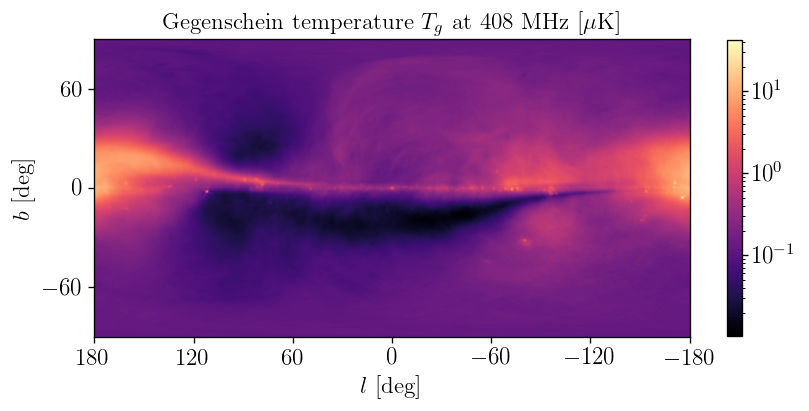

In [46]:
plot_lb(1e6*Ig_full_intg_map*prefac(nu_haslam), title=r'Gegenschein temperature $T_{g}$ at 408 MHz [$\mu$K]')

## 2. Front gegenschein

In [21]:
db = b_s[1] - b_s[0]
dl = l_s[1] - l_s[0]
r_kernel_max = 30 # pixels
kernel_b_s = jnp.linspace(-r_kernel_max, r_kernel_max, 2*r_kernel_max+1)
kernel_l_s = jnp.linspace(-r_kernel_max, r_kernel_max, 2*r_kernel_max+1)
kernel_b_grid, kernel_l_grid = jnp.meshgrid(kernel_b_s, kernel_l_s)
kernel_angle_dist_sq = kernel_b_grid**2 + kernel_l_grid**2

@jit
def Ifg_slice(xs_start, xs_end, xd_start, xd_end):
    """xs: [kpc], xd: [kpc]"""
    xs = (xs_start + xs_end) / 2
    xd = (xd_start + xd_end) / 2
    dxs = jnp.abs(xs_start - xs_end)
    dxd = jnp.abs(xd_start - xd_end)
    
    lbd_flat = jnp.stack([
        l_grid.flatten(),
        b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xs)
    ], axis=-1)
    power_density_map = power_density(GCstz(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    lbd_flat = jnp.stack([
        l_grid.flatten(),
        b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xd)
    ], axis=-1)
    rho_map = rho_NFW(Gr(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    slice_map = power_density_map * rho_map * dxs * dxd * kpc * norm_map
    
    smooth_r = jnp.arcsin(jnp.sin(2*sigmad_over_c) * (xd - xs) / xs) # [rad]
    kernel = jnp.exp(-kernel_angle_dist_sq / (2*smooth_r**2))
    kernel /= jnp.sum(kernel)
    return convolve2d(slice_map, kernel, mode='same', boundary='fill')

def Ifg_map(theta_i0):
    
    full_map = np.zeros((n_b_pix, n_l_pix))
    xss = intg_d_s
    
    for i_xs in tqdm(range(len(xss)-1)):
        xs = (xss[i_xs] + xss[i_xs+1]) / 2
        xds = jnp.geomspace(xs, x_d_fgmax(xs, theta_i0), 100) # [kpc]
        for i_xd in range(len(xds)-1):
            full_map += Ifg_slice(xss[i_xs], xss[i_xs+1], xds[i_xd], xds[i_xd+1])
            
    return full_map

In [22]:
Tfg_intg_map = prefac(nu_haslam) * Ifg_map(theta_i0=2*jnp.pi/3)

  0%|          | 0/499 [00:00<?, ?it/s]

In [23]:
with h5py.File(f"../outputs/gsr/Tfg_408MHz_field{scheme}.h5", 'w') as hf:
    hf.create_dataset('b_edge_s', data=np.array(b_edge_s))
    hf.create_dataset('l_edge_s', data=np.array(l_edge_s))
    hf.create_dataset('b_s', data=np.array(b_s))
    hf.create_dataset('l_s', data=np.array(l_s))
    hf.create_dataset('Tfg', data=np.array(Tfg_intg_map))

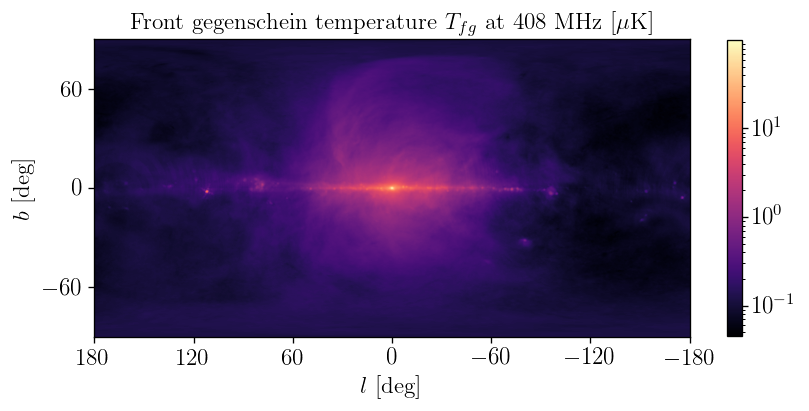

In [24]:
plot_lb(1e6 * Tfg_intg_map, title=r'Front gegenschein temperature $T_{fg}$ at 408 MHz [$\mu$K]')

## 3. Forwardschein

In [25]:
@jit
def If_slice(xs_start, xs_end, xd_start, xd_end):
    """xs: [kpc], xd: [kpc]"""
    xs = (xs_start + xs_end) / 2
    xd = (xd_start + xd_end) / 2
    dxs = jnp.abs(xs_start - xs_end)
    dxd = jnp.abs(xd_start - xd_end)
    
    lbd_flat = jnp.stack([
        l_grid.flatten(),
        b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xs)
    ], axis=-1)
    power_density_map = power_density(GCstz(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    lbd_flat = jnp.stack([
        l_grid.flatten(),
        b_grid.flatten(),
        jnp.full((n_b_pix*n_l_pix,), xd)
    ], axis=-1)
    rho_map = rho_NFW(Gr(lbd_flat)).reshape(n_b_pix, n_l_pix)
    
    slice_map = power_density_map * rho_map * dxs * dxd * kpc * norm_map
    return slice_map

def If_map(theta_i0):
    
    full_map = np.zeros((n_b_pix, n_l_pix))
    xss = intg_d_s
    
    for i_xs in tqdm(range(len(xss)-1)):
        xs = (xss[i_xs] + xss[i_xs+1]) / 2
        xds = jnp.geomspace(0.01, xs, 100) # [kpc]
        for i_xd in range(len(xds)-1):
            full_map += If_slice(xss[i_xs], xss[i_xs+1], xds[i_xd], xds[i_xd+1])
            
    return full_map

In [26]:
Tf_intg_map = prefac(nu_haslam) * If_map(theta_i0=2*jnp.pi/3)

  0%|          | 0/499 [00:00<?, ?it/s]

In [27]:
with h5py.File(f"../outputs/gsr/Tf_408MHz_field{scheme}.h5", 'w') as hf:
    hf.create_dataset('b_edge_s', data=np.array(b_edge_s))
    hf.create_dataset('l_edge_s', data=np.array(l_edge_s))
    hf.create_dataset('b_s', data=np.array(b_s))
    hf.create_dataset('l_s', data=np.array(l_s))
    hf.create_dataset('Tf', data=np.array(Tf_intg_map))

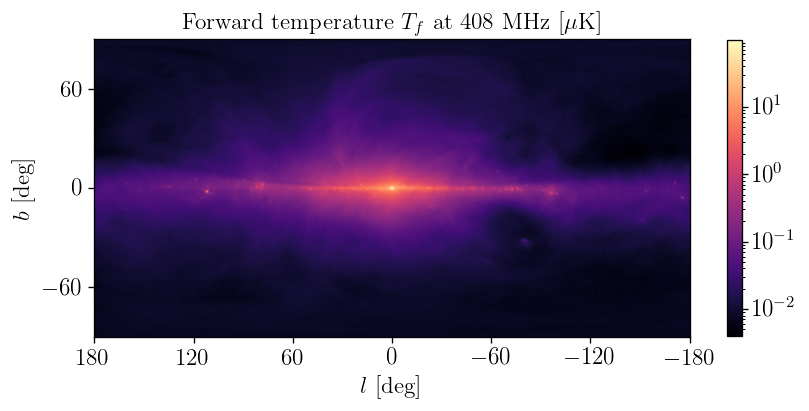

In [29]:
plot_lb(1e6 * Tf_intg_map, title=r'Forward temperature $T_{f}$ at 408 MHz [$\mu$K]')

## 4. Sum everything

In [31]:
sum_map = np.zeros_like(l_grid)

for k in ['g', 'fg', 'f']:
    with h5py.File(f"../outputs/gsr/T{k}_408MHz_field{scheme}.h5", 'r') as hf:
        sum_map += hf[f'T{k}'][:]

with h5py.File(f"../outputs/gsr/Ta_408MHz_field{scheme}.h5", 'w') as hf:
    hf.create_dataset('b_edge_s', data=np.array(b_edge_s))
    hf.create_dataset('l_edge_s', data=np.array(l_edge_s))
    hf.create_dataset('b_s', data=np.array(b_s))
    hf.create_dataset('l_s', data=np.array(l_s))
    hf.create_dataset('Ta', data=np.array(sum_map))

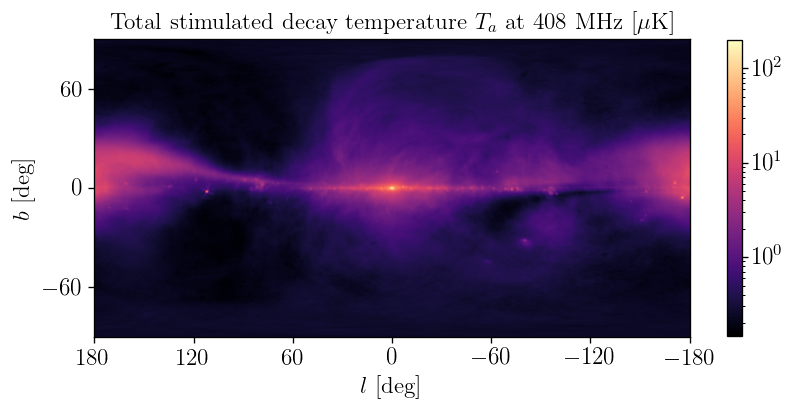

In [32]:
plot_lb(1e6 * sum_map, title=r'Total stimulated decay temperature $T_a$ at 408 MHz [$\mu$K]')